In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [5]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
# Load the data
file_path = "../data/processed/imputedData.csv"
data = pd.read_csv(file_path)

In [9]:
import matplotlib.pyplot as plt

def inject_and_label_anomalies(data: pd.DataFrame, target_anomaly_rate: float = 0.15):
    """
    Parameters:
        data (pd.DataFrame): The dataset containing 'inside_temperature' and 'inside_humidity'.
        target_anomaly_rate (float): The target percentage of synthetic anomalies to inject.

    Returns:
        tuple: Modified dataset with anomalies as new rows, DataFrame with anomaly labels.
    """
    data_with_anomalies = data.copy()
    np.random.seed(42)

    lower_temp_threshold = -10
    upper_temp_threshold = 65
    lower_hum_threshold =  0
    upper_hum_threshold =  95

    # Identify natural anomalies
    labels = pd.DataFrame({'anomaly': 0}, index=data_with_anomalies.index)
    labels.loc[
        (data_with_anomalies['inside_temperature'] < lower_temp_threshold) | (data_with_anomalies['inside_temperature'] > upper_temp_threshold) |
        (data_with_anomalies['inside_humidity'] < lower_hum_threshold) | (data_with_anomalies['inside_humidity'] > upper_hum_threshold),
        'anomaly'
    ] = 1
    

    print(f"Normal anomalies count: {(labels['anomaly']==1).sum()}")
    
    # Visualize natural anomalies
    plt.figure(figsize=(12, 6))

    # Plot boxplot for inside temperature
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data_with_anomalies['inside_temperature'], color='skyblue')
    plt.title('Inside Temperature')
    plt.ylabel('Temperature (°C)')

    # Plot boxplot for inside humidity
    plt.subplot(1, 2, 2)
    sns.boxplot(y=data_with_anomalies['inside_humidity'], color='lightgreen')
    plt.title('Inside Humidity')
    plt.ylabel('Humidity (%)')

    plt.tight_layout()
    plt.show()
    
    # Inject synthetic anomalies as new rows
    num_synthetic_anomalies = int(len(data_with_anomalies) * target_anomaly_rate)
    synthetic_anomalies = data.sample(n=num_synthetic_anomalies, replace=False).copy()
    synthetic_anomalies['inside_temperature'] += np.random.uniform(65, 100, size=num_synthetic_anomalies)
    synthetic_anomalies['inside_humidity'] += np.random.uniform(-10, 20, size=num_synthetic_anomalies)

    synthetic_labels = pd.DataFrame({'anomaly': 1}, index=synthetic_anomalies.index)

    # Combine original data with synthetic anomalies
    data_with_anomalies = pd.concat([data_with_anomalies, synthetic_anomalies], ignore_index=True)
    labels = pd.concat([labels, synthetic_labels], ignore_index=True)


    # Visualize injected anomalies
    plt.figure(figsize=(12, 6))

    # Plot boxplot for inside temperature
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data_with_anomalies['inside_temperature'], color='skyblue')
    plt.title('Inside Temperature')
    plt.ylabel('Temperature (°C)')

    # Plot boxplot for inside humidity
    plt.subplot(1, 2, 2)
    sns.boxplot(y=data_with_anomalies['inside_humidity'], color='lightgreen')
    plt.title('Inside Humidity')
    plt.ylabel('Humidity (%)')

    # Display the plots
    plt.tight_layout()
    plt.show()

    return data_with_anomalies, labels

In [11]:
def preprocess_data(data):
    """
    Preprocess data with null value handling
    """
    data['time'] = pd.to_datetime(data['time'])

    processed_data = data.copy()
    
    # Drop house column if exists
    if 'house' in processed_data.columns:
        processed_data = processed_data.drop('house', axis=1)
    
    # Time features
    processed_data['hour'] = processed_data['time'].dt.hour
    processed_data['day_of_week'] = processed_data['time'].dt.dayofweek
    processed_data['month'] = processed_data['time'].dt.month
    processed_data['day'] = processed_data['time'].dt.day
    processed_data['is_weekend'] = processed_data['day_of_week'].isin([5, 6]).astype(int)
    
    # Handle missing values
    numerical_cols = ['outside_temperature', 'outside_humidity','BP','WS','WD_Avg','WSgust_Max','Rain_mm_Tot',
                     'hour', 'day_of_week', 'month', 'day']
    
    # For numerical columns: interpolate between values, then forward/backward fill any remaining nulls
    for col in numerical_cols:
        if col in processed_data.columns:
            processed_data[col] = (processed_data[col]
                                 .interpolate(method='linear')
                                 .fillna(method='ffill')
                                 .fillna(method='bfill'))
    
    # For categorical columns: fill with mode
    categorical_cols = processed_data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'time':  # Skip time column
            processed_data[col] = processed_data[col].fillna(processed_data[col].mode()[0])
    
    # One-hot encode categorical features
    processed_data = pd.get_dummies(processed_data, columns=['zone', 'device_id'])
    
    # Scale numerical features
    scaler = StandardScaler()
    processed_data[numerical_cols] = scaler.fit_transform(processed_data[numerical_cols])
    
    # Verify no nulls remain
    assert processed_data.isnull().sum().sum() == 0, "Null values remain after preprocessing"
    
    return processed_data, scaler

Normal anomalies count: 0


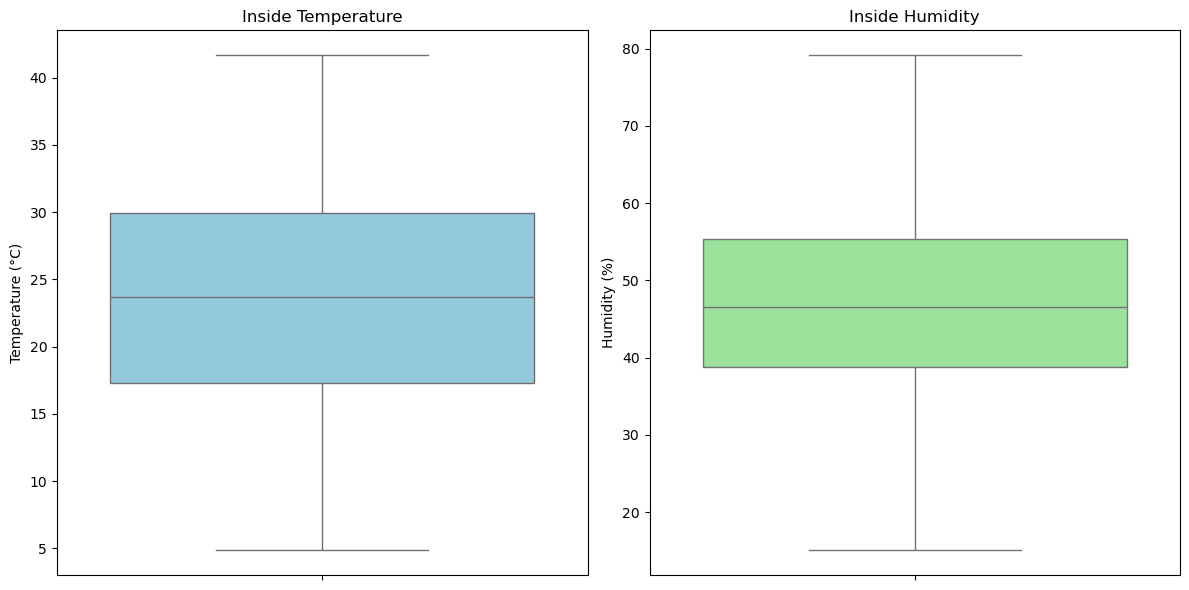

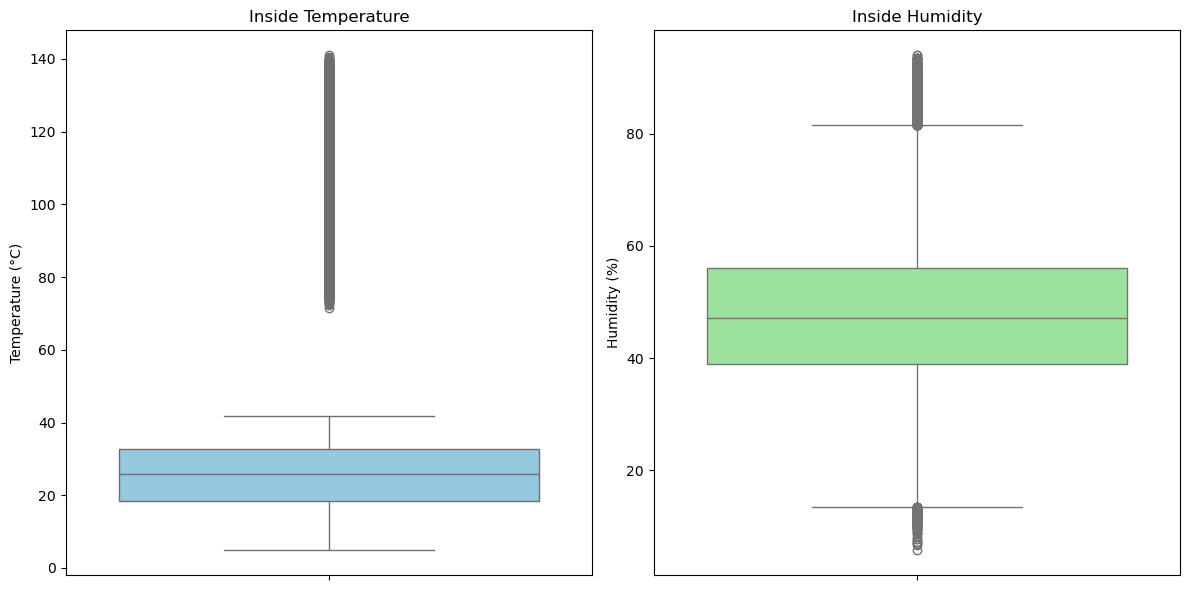


Preprocessing data...


In [13]:
data_with_anomalies, labels = inject_and_label_anomalies(data)


print("\nPreprocessing data...")
processed_data, scaler = preprocess_data(data_with_anomalies)
    
# Prepare features
X = processed_data.drop(['time'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [15]:
params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.02,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 1.0,
}

model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
y_pred = model.predict(X_test)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [19]:
data , scaler  = preprocess_data(data)
data = data.drop(['time'], axis=1)
orignal_predictions = model.predict(data)


In [21]:
import os

# Check if original data is anomaly-free
if np.all(orignal_predictions == 0):
    print("Original data is anomaly-free.")
    
    anomaly_free_dir = "../data/anomaly_free"
    os.makedirs(anomaly_free_dir, exist_ok=True)
    
    anomaly_free_path = os.path.join(anomaly_free_dir, "anomaly_free_data.csv")
    
    # Save the data
    data.to_csv(anomaly_free_path, index=False)
    print(f"Anomaly-free data saved to {anomaly_free_path}")
else:
    print("Anomalies detected in original data.")



Original data is anomaly-free.
Anomaly-free data saved to ../data/anomaly_free\anomaly_free_data.csv


In [23]:
import os
import joblib

models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

model_path = os.path.join(models_dir, "xgb_anomaly_detection_model.pkl")

# Save the model
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

Model saved to ../models\xgb_anomaly_detection_model.pkl


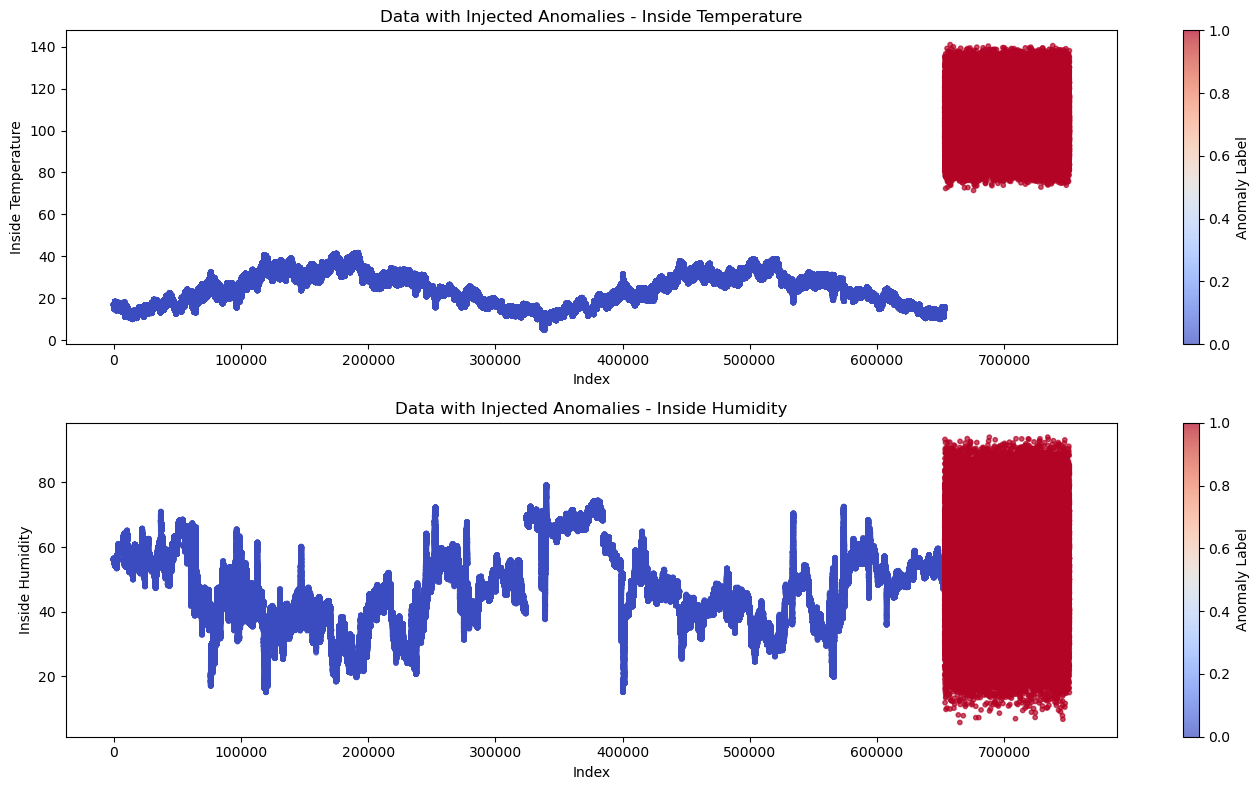

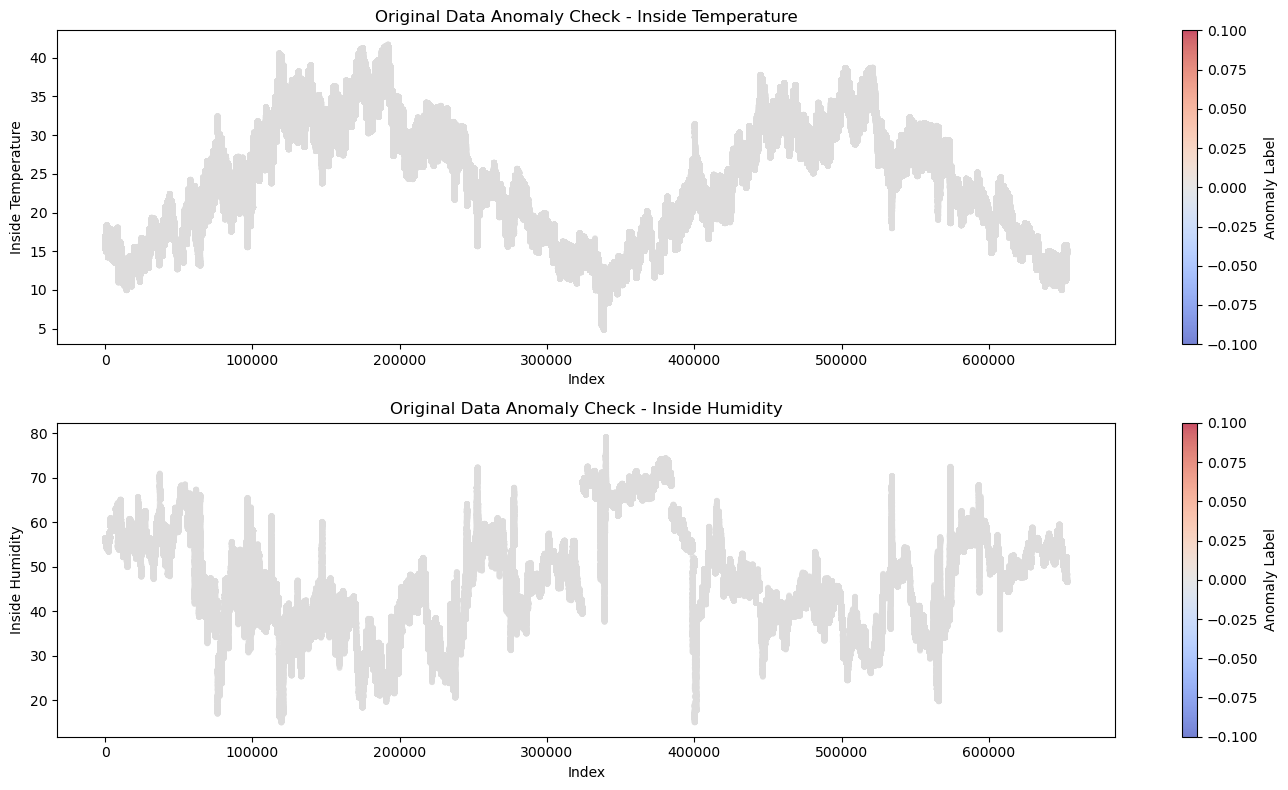

In [25]:
def visualize_anomalies(data_with_anomalies, labels, title="Data with Anomalies"):
    plt.figure(figsize=(14, 8))

    labels = np.array(labels)

    plt.subplot(2, 1, 1)
    plt.scatter(data_with_anomalies.index, data_with_anomalies['inside_temperature'], 
                c=labels, cmap='coolwarm', alpha=0.7, s=10)
    plt.title(f"{title} - Inside Temperature")
    plt.xlabel("Index")
    plt.ylabel("Inside Temperature")
    plt.colorbar(label="Anomaly Label")

    plt.subplot(2, 1, 2)
    plt.scatter(data_with_anomalies.index, data_with_anomalies['inside_humidity'], 
                c=labels, cmap='coolwarm', alpha=0.7, s=10)
    plt.title(f"{title} - Inside Humidity")
    plt.xlabel("Index")
    plt.ylabel("Inside Humidity")
    plt.colorbar(label="Anomaly Label")

    plt.tight_layout()
    plt.show()

visualize_anomalies(data_with_anomalies, labels, title="Data with Injected Anomalies")

orignal_predictions_numeric = np.array(orignal_predictions)
visualize_anomalies(data, orignal_predictions_numeric, title="Original Data Anomaly Check")


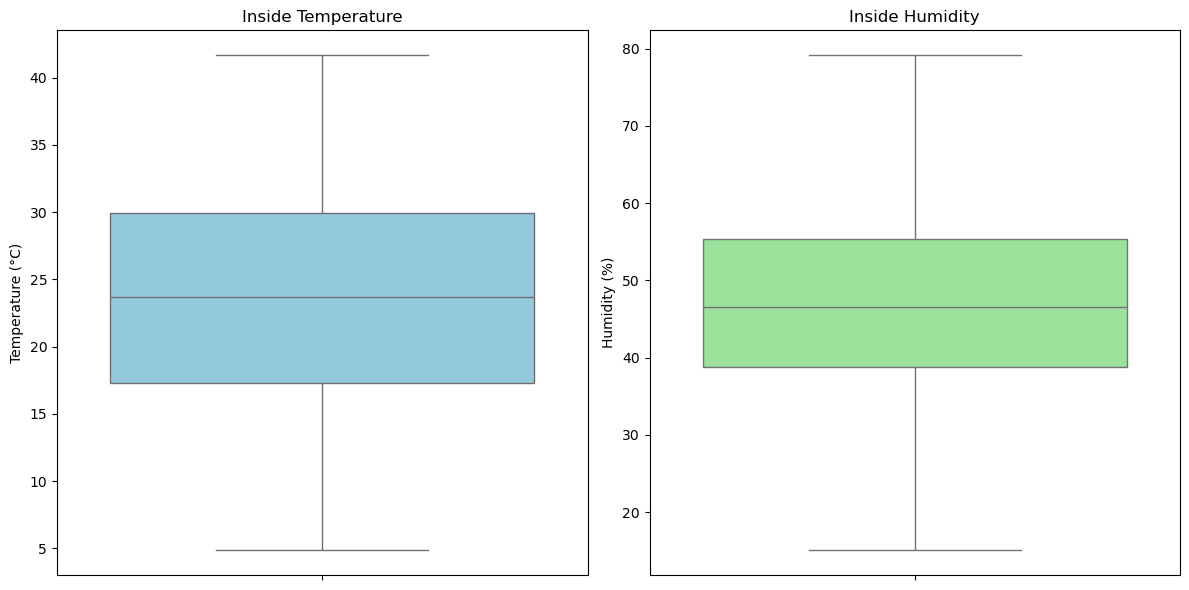

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize a Matplotlib figure
plt.figure(figsize=(12, 6))

# Plot boxplot for inside temperature
plt.subplot(1, 2, 1)
sns.boxplot(y=data['inside_temperature'], color='skyblue')
plt.title('Inside Temperature')
plt.ylabel('Temperature (°C)')

# Plot boxplot for inside humidity
plt.subplot(1, 2, 2)
sns.boxplot(y=data['inside_humidity'], color='lightgreen')
plt.title('Inside Humidity')
plt.ylabel('Humidity (%)')

# Display the plots
plt.tight_layout()
plt.show()


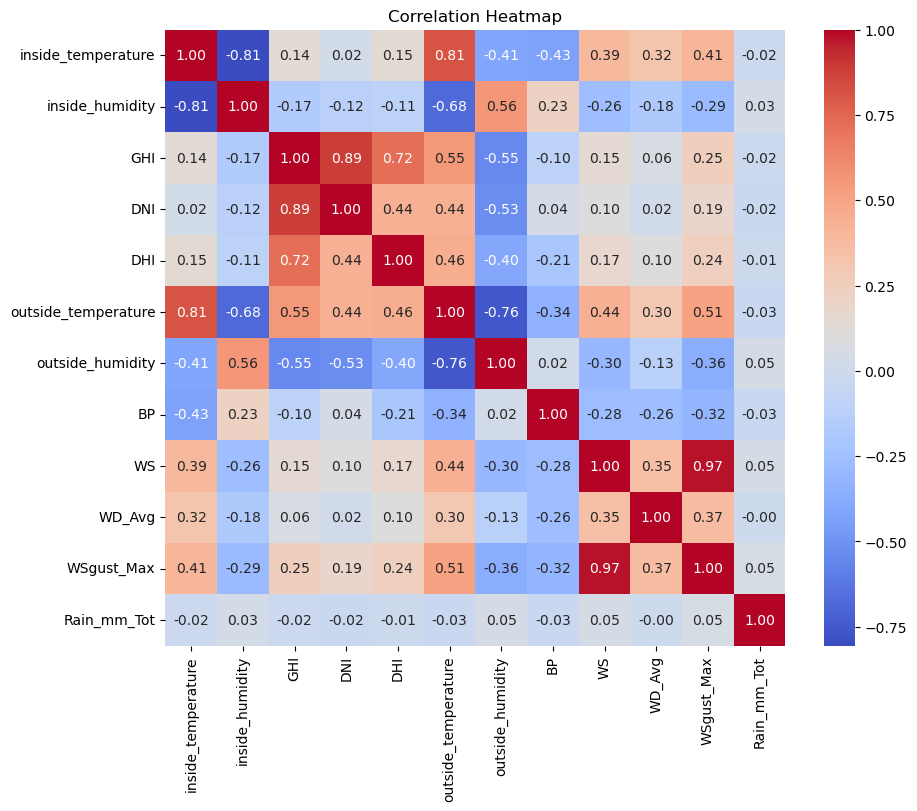

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
file_path = "../data/processed/imputedData.csv"
data = pd.read_csv(file_path)
data = data.drop(['time'], axis=1)
data = data.drop(['zone'], axis=1)
data = data.drop(['house'], axis=1)
data = data.drop(['device_id'], axis=1)

correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()
